In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import tensorflow as tf
import numpy as np
import random

SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

1. encoder 제거
2. positional embedding을 학습가능한 embedding 층으로 대체
3. decoder block에 masked self attention만 수행
4. 기존의 addnorm, dense 구조 유지
5. loss 함수에서 context 부분과 padding 부분은 loss에 포함시키지 않도록 수정
6. weight tying

#1.기본gpt구조

##1.1재료

In [3]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, kernel_initializer='glorot_uniform', name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model
    self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model,kernel_initializer=self.kernel_initializer)
    self.key_dense = tf.keras.layers.Dense(units=d_model,kernel_initializer=self.kernel_initializer)
    self.value_dense = tf.keras.layers.Dense(units=d_model,kernel_initializer=self.kernel_initializer)

    self.dense = tf.keras.layers.Dense(units=d_model,kernel_initializer=self.kernel_initializer)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query,batch_size)
    key = self.split_heads(key,batch_size)
    value = self.split_heads(value,batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [5]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [6]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


#1.2decoder-only

In [7]:
def position_gen(inputs):
  batch_size=tf.shape(inputs)[0]
  seq_len=tf.shape(inputs)[1]
  positions = tf.range(start=0, limit=seq_len, delta=1)
  positions = tf.expand_dims(positions, 0)
  positions = tf.tile(positions, [batch_size, 1])
  return positions

In [8]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layeraa(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  initializer = tf.keras.initializers.GlorotUniform(seed=42)

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, kernel_initializer=initializer, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.Dropout(rate=dropout)(attention1)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu',kernel_initializer=initializer)(attention2)
  outputs = tf.keras.layers.Dense(units=d_model,kernel_initializer=initializer)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

##encoder부분 다 들어내고 decoder 흐름이 잘 연결되도록 마스크랑 구성

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [9]:
def decoderaa(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            max_len,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  initializer = tf.keras.initializers.GlorotUniform(seed=42)
  # 임베딩 레이어
  embedding_layer = tf.keras.layers.Embedding(vocab_size, d_model,embeddings_initializer=initializer)
  embeddings=embedding_layer(inputs)
  #embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  positions = tf.keras.Input(shape=(None,), name='positions')
  position_embeddings = tf.keras.layers.Embedding(max_len, d_model,embeddings_initializer=initializer)(positions)

  embeddings += position_embeddings

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layeraa(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, look_ahead_mask])

  embedding_weights = embedding_layer.weights[0]
  outputs = tf.keras.layers.Lambda(lambda x: tf.matmul(x[0],x[1],transpose_b=True),output_shape=(None,vocab_size))([outputs,embedding_weights])

  return tf.keras.Model(
      inputs=[inputs, positions,look_ahead_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


#2.데이터

In [10]:
data=pd.read_csv('ChatbotData.csv')

In [11]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?!,])", r" \1 ", sentence).lower()

  sentence = re.sub(r'[^가-힣a-zA-Z0-9.,?!\s]', ' ', sentence)
  sentence = re.sub(r'\s+', " ", sentence)
  sentence = re.sub(r'^\s+|\s+$', '', sentence)

  return sentence
print("슝=3")

슝=3


In [12]:
data['A_']=data['A'].apply(preprocess_sentence)
data['Q_']=data['Q'].apply(preprocess_sentence)

inputs=np.array(data['Q_'])
outputs=np.array(data['A_'])

In [13]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(inputs + outputs, target_vocab_size=2**14)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [14]:
lens=[]
for i in range(len(inputs)):
  lens.append(len(tokenizer.encode(outputs[i])))

print(np.array(lens).mean())

5.593504186754631


<AxesSubplot:ylabel='Density'>

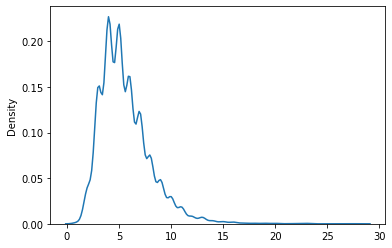

In [15]:
import seaborn as sns

sns.kdeplot(lens)

In [16]:
MAX_LENGTH = 17
VOCAB_SIZE = tokenizer.vocab_size

In [17]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  decoder_inputs=[]

  for (sentence1, sentence2) in zip(inputs, outputs):
    sentence1 = tokenizer.encode(sentence1)
    sentence2 = tokenizer.encode(sentence2)

    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  for (sentence1, sentence2) in zip(tokenized_inputs, tokenized_outputs):
    combined = np.concatenate([sentence1, sentence2], axis=0)
    decoder_inputs.append(combined)

  return np.array(decoder_inputs)

In [18]:
decoder_inputs = tokenize_and_filter(inputs, outputs)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(decoder_inputs)))

단어장의 크기 : 10457
필터링 후의 질문 샘플 개수: 11788


In [29]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000
SEED = 42


# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'dec_inputs': decoder_inputs[:, :-1]
    },
    {
        'decoder': decoder_inputs[:, 1:]
    },
))

total_size=len(dataset)

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE, seed=SEED)

train_size = int(0.8 * total_size)
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


#3.model 구성

In [44]:
def transformeraa(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                max_len,
                name="transformer"):
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  positions=tf.keras.layers.Lambda(
      position_gen,
      output_shape=(None,d_model),
      name='positions')(dec_inputs)

  # 디코더
  dec_outputs = decoderaa(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
      max_len=max_len
  )(inputs=[dec_inputs, positions, look_ahead_mask])

  # 완전연결층
  #outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=dec_inputs, outputs=dec_outputs, name=name)
print("슝=3")

슝=3


In [45]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

model = transformeraa(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_len=MAX_LENGTH*2-1)

model.summary()

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'embedding/embeddings:0' shape=(10457, 256) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'embedding/embeddings:0' shape=(10457, 256) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
positions (Lambda)              (None, None)         0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 10457)  4793856     dec_inputs[0][0]                 
                                                                 positions[0][0]        

#4.train

In [46]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH*2 - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)
  front_mask = tf.concat([
      tf.zeros((tf.shape(y_true)[0], 16)),
      tf.ones((tf.shape(y_true)[0], tf.shape(y_true)[1] - 16))
  ], axis=1)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  final_mask = mask * front_mask
  loss = tf.multiply(loss, final_mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


In [49]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [50]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH*2 - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [51]:
EPOCHS = 200
tf.random.set_seed(SEED)
history=model.fit(train_dataset,validation_data=val_dataset, epochs=EPOCHS, verbose=1)

Epoch 1/200
148/148 [==============================] - 15s 70ms/step - loss: 1.5053 - accuracy: 0.0202 - val_loss: 1.4292 - val_accuracy: 0.0344
Epoch 2/200
148/148 [==============================] - 9s 64ms/step - loss: 1.3405 - accuracy: 0.0344 - val_loss: 1.2285 - val_accuracy: 0.0342
Epoch 3/200
148/148 [==============================] - 10s 65ms/step - loss: 1.1950 - accuracy: 0.0346 - val_loss: 1.1523 - val_accuracy: 0.0344
Epoch 4/200
148/148 [==============================] - 10s 65ms/step - loss: 1.1475 - accuracy: 0.0324 - val_loss: 1.1175 - val_accuracy: 0.0296
Epoch 5/200
148/148 [==============================] - 10s 65ms/step - loss: 1.1237 - accuracy: 0.0299 - val_loss: 1.0959 - val_accuracy: 0.0296
Epoch 6/200
148/148 [==============================] - 10s 65ms/step - loss: 1.0804 - accuracy: 0.0308 - val_loss: 1.0402 - val_accuracy: 0.0324
Epoch 7/200
148/148 [==============================] - 10s 64ms/step - loss: 1.0472 - accuracy: 0.0328 - val_loss: 0.9963 - val_acc

148/148 [==============================] - 10s 65ms/step - loss: 0.0435 - accuracy: 0.1580 - val_loss: 0.0054 - val_accuracy: 0.1662
Epoch 58/200
148/148 [==============================] - 10s 64ms/step - loss: 0.0418 - accuracy: 0.1589 - val_loss: 0.0051 - val_accuracy: 0.1680
Epoch 59/200
148/148 [==============================] - 10s 64ms/step - loss: 0.0403 - accuracy: 0.1584 - val_loss: 0.0048 - val_accuracy: 0.1700
Epoch 60/200
148/148 [==============================] - 10s 64ms/step - loss: 0.0405 - accuracy: 0.1594 - val_loss: 0.0043 - val_accuracy: 0.1682
Epoch 61/200
148/148 [==============================] - 9s 64ms/step - loss: 0.0368 - accuracy: 0.1599 - val_loss: 0.0038 - val_accuracy: 0.1707
Epoch 62/200
148/148 [==============================] - 10s 64ms/step - loss: 0.0374 - accuracy: 0.1594 - val_loss: 0.0042 - val_accuracy: 0.1666
Epoch 63/200
148/148 [==============================] - 10s 65ms/step - loss: 0.0362 - accuracy: 0.1598 - val_loss: 0.0036 - val_accuracy:

148/148 [==============================] - 10s 64ms/step - loss: 0.0149 - accuracy: 0.1654 - val_loss: 0.0016 - val_accuracy: 0.1695
Epoch 114/200
148/148 [==============================] - 10s 65ms/step - loss: 0.0144 - accuracy: 0.1663 - val_loss: 0.0017 - val_accuracy: 0.1694
Epoch 115/200
148/148 [==============================] - 10s 65ms/step - loss: 0.0144 - accuracy: 0.1660 - val_loss: 0.0014 - val_accuracy: 0.1707
Epoch 116/200
148/148 [==============================] - 10s 65ms/step - loss: 0.0142 - accuracy: 0.1659 - val_loss: 0.0019 - val_accuracy: 0.1687
Epoch 117/200
148/148 [==============================] - 10s 65ms/step - loss: 0.0144 - accuracy: 0.1658 - val_loss: 0.0013 - val_accuracy: 0.1698
Epoch 118/200
148/148 [==============================] - 10s 65ms/step - loss: 0.0139 - accuracy: 0.1665 - val_loss: 0.0016 - val_accuracy: 0.1684
Epoch 119/200
148/148 [==============================] - 10s 65ms/step - loss: 0.0141 - accuracy: 0.1652 - val_loss: 0.0016 - val_ac

Epoch 169/200
148/148 [==============================] - 10s 65ms/step - loss: 0.0093 - accuracy: 0.1671 - val_loss: 0.0013 - val_accuracy: 0.1696
Epoch 170/200
148/148 [==============================] - 10s 65ms/step - loss: 0.0094 - accuracy: 0.1683 - val_loss: 0.0015 - val_accuracy: 0.1687
Epoch 171/200
148/148 [==============================] - 9s 64ms/step - loss: 0.0090 - accuracy: 0.1678 - val_loss: 0.0012 - val_accuracy: 0.1687
Epoch 172/200
148/148 [==============================] - 10s 65ms/step - loss: 0.0089 - accuracy: 0.1672 - val_loss: 0.0018 - val_accuracy: 0.1669
Epoch 173/200
148/148 [==============================] - 10s 65ms/step - loss: 0.0091 - accuracy: 0.1674 - val_loss: 0.0012 - val_accuracy: 0.1695
Epoch 174/200
148/148 [==============================] - 10s 64ms/step - loss: 0.0085 - accuracy: 0.1679 - val_loss: 0.0010 - val_accuracy: 0.1693
Epoch 175/200
148/148 [==============================] - 10s 65ms/step - loss: 0.0083 - accuracy: 0.1678 - val_loss: 0.

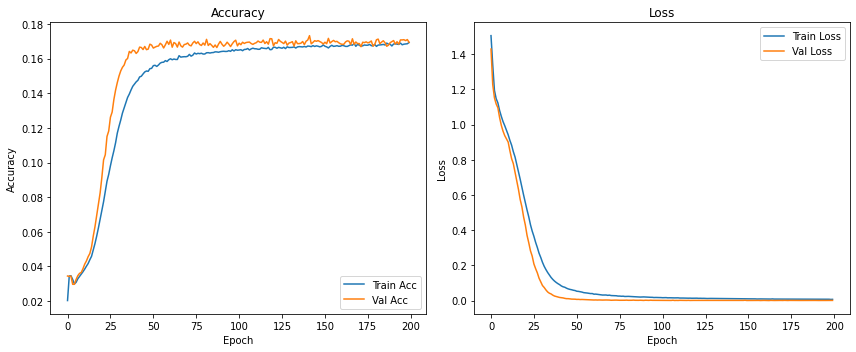

In [52]:
import matplotlib.pyplot as plt

# history에서 metric 추출
acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

# plot
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

#5.inference

In [76]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]

  sentence = tf.expand_dims(tokenizer.encode(sentence),axis=0)
  if len(sentence) <= MAX_LENGTH:
    sentence = tf.concat([sentence, tf.zeros((1, MAX_LENGTH - len(sentence)),dtype=sentence.dtype)], axis=-1)
  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = sentence

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 pad 토큰이라면 for문을 종료
    if tf.equal(predicted_id, 0):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
    
    


  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [84]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  prediction = prediction[18:]

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size and i !=0])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [89]:
for x, y in val_dataset.take(1):
    dec_inputs = x['dec_inputs']    # dict에서 꺼내
    tokens = dec_inputs[:, :17]      # slicing
    for token_seq in tokens:         # batch 안에서 하나씩
        print(tokenizer.decode([t for t in token_seq.numpy() if t != 0]))

흰머리 보여
기다림 속에 갇혀 있어
나를 너무 오래 기다리게했어
강아지 좋아하는 여자 어때 ?
중고로 사길 잘 한거 같아
대학 가고 싶다.
어른이 된다는 건 뭘까
먼지가 너무 많아
사랑이라는 이름으로
잘 살겠지 라고 생각하자
어디서 피해자 코스프레임 ?
속았나
양키캔들 선물받았어
남자후폭풍
이별후 재회 그리고
늦어지고 있는데 변명이 생각 안나
이력서 쓰고 있어.
머리 또 잘라야 돼
연락하고 지내는데
나 쉬운 여자 아니야
싸구려 인생
사랑 받는 느낌을 못 받아
지치네
문자 보내놓은지 어언 한 달.
같은 반인데 헤어지자고 해야 하나 ? ?
서울 근교에서 갈만한 곳 추천
남자친구가 이벤트 해 주면 좋겠다.
향수 뭐로 할까
잘 지냈어 ?
답정녀 좀 싫어
코딩 좀 배울까
잠들기 직전 일어난 직후는 죽을 것 같네
인형뽑기는 유행 지났지 ?
좀 쉬면서 애기 키워야 할 듯
오랜만에 스테끼 먹고 싶어
썸 타는 중인데 난 직장인이고 얘는 학생이야.
아직도 꿈같고 너무 괴로워
내가 쓸모없는 인간 같아
어째야 할까
만나면 좋은 사람이 있어. 헤헤
이별후 3일째
부모님이 이혼할 거 같아
넌 잘살더라
썸남이 같이 운동하자는데 가능 ?
한달 ! ! 하고 일주일
절망적인데
말을 왜 이렇게 못 알아 듣니
전화 못하겠어
그 남자를 좋아해도 되는지 고민이야.
남친이 나를 안 좋아하는 것 같은데 내가 붙잡고 있는 것 같아.
남사친이랑 잘 맞아서 카톡이 끊어지지 않는데 이거 그린라이트일까 ?
탄생의 이유 알아 ?
너 뭐하는 애야
어제 연락이 왔어. 제가 매달려서 온거같아
그녀를 만났던 카페에서 탈퇴했어
겨울에 하는 이별
신기한 일들이 많이 일어나
회식하는데 나만 챙겨줘. 썸임 ?
여자친구가 자주 씻지를 않아.
이 사람이랑 결혼이 옳은 걸까 ?
업무 지적을 너무 많이 받아
너무 마른 거 같아
나 좀 쩌는 듯
내가 좋아하는 사람이 나 안 좋아하는 거 같아


In [85]:
sentence_generation('내가 좋아하는 사람이 나 안 좋아하는 거 같아')

입력 : 내가 좋아하는 사람이 나 안 좋아하는 거 같아
출력 : 슬픈 이야기네요...............


'슬픈 이야기네요...............'

#6.masked_gpt

In [94]:
def create_diag_mask(x):
  batch=tf.shape(x)[0]
  seq_len = tf.shape(x)[1]
  diag = tf.eye(num_rows=seq_len, num_columns=seq_len)  # (S, S)
  diag = tf.repeat(diag[tf.newaxis,:,:], repeats=batch , axis=0)
  return diag[:, :, :, tf.newaxis] # (B, S, S, D)

In [107]:
class MultiHeadAttention2(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, kernel_initializer='glorot_uniform',name="multi_head_attention"):
    super(MultiHeadAttention2, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model
    self.kernel_initializer = tf.keras.initializers.get(kernel_initializer)

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model,kernel_initializer=self.kernel_initializer)
    self.key_dense = tf.keras.layers.Dense(units=d_model,kernel_initializer=self.kernel_initializer)
    self.value_dense = tf.keras.layers.Dense(units=d_model,kernel_initializer=self.kernel_initializer)

    self.dense = tf.keras.layers.Dense(units=d_model,kernel_initializer=self.kernel_initializer)

  def split_heads(self, inputs, batch_size, seq_len):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, seq_len, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 3, 1, 2, 4])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]
    seq_len=tf.shape(query)[1]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query,batch_size,tf.shape(query)[2])
    key = self.split_heads(key,batch_size,tf.shape(key)[2])
    value = self.split_heads(value,batch_size,tf.shape(value)[2])

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 3, 1, 4])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, seq_len, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [108]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs2 = tf.keras.Input(shape=(None, None, d_model), name="inputs2")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None, None), name="look_ahead_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention2(
      d_model, num_heads, kernel_initializer=initializer, name="attention_1")(inputs={
          'query': inputs2,
          'key': inputs2,
          'value': inputs2,
          'mask': look_ahead_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.Dropout(rate=dropout)(attention1)
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu',kernel_initializer=initializer)(attention1)
  outputs = tf.keras.layers.Dense(units=d_model,kernel_initializer=initializer)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)

  return tf.keras.Model(
      inputs=[inputs2,look_ahead_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [124]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            max_len,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None, None), name='look_ahead_mask')

  # 임베딩 레이어
  embedding_layer = tf.keras.layers.Embedding(vocab_size, d_model,embeddings_initializer=initializer)
  embeddings = embedding_layer(inputs)
  #embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  positions = tf.keras.Input(shape=(None,), name='positions')
  position_embeddings = tf.keras.layers.Embedding(max_len, d_model,embeddings_initializer=initializer)(positions)

  embeddings += position_embeddings

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  outputs2 = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1),output_shape=(1,None,d_model))(outputs)
  outputs2 = tf.keras.layers.Lambda(lambda x: tf.repeat(x, repeats=tf.shape(x)[2], axis=1),output_shape=(None,None,d_model))(outputs2)
  diag_mask = tf.keras.layers.Lambda(create_diag_mask)(outputs2)
  for i in range(num_layers):
    if i >= 1:
      outputs = tf.keras.layers.Lambda(lambda x : tf.multiply(x[0], x[1]),output_shape=(None,None,d_model))([diag_mask,outputs])
    outputs2 = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs2, look_ahead_mask])

  final_outputs = tf.keras.layers.Lambda(lambda x: tf.transpose(tf.linalg.diag_part(tf.transpose(x, perm=[0,3,1,2])),perm=[0,2,1]),output_shape=(None, d_model))(outputs2)
  embedding_weights = embedding_layer.weights[0]
  outputs2 = tf.keras.layers.Lambda(lambda x: tf.matmul(x[0],x[1],transpose_b=True),output_shape=(None,vocab_size))([final_outputs,embedding_weights])

  return tf.keras.Model(
      inputs=[inputs, positions, look_ahead_mask],
      outputs=outputs2,
      name=name)
print("슝=3")

슝=3


In [125]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                max_len,
                name="transformer"):
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_real_mask,
      output_shape=(1, None, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
      max_len=max_len
  )(inputs=[dec_inputs, look_ahead_mask])

  # 완전연결층
  # final_outputs = tf.keras.layers.Lambda(lambda x: tf.transpose(tf.linalg.diag_part(tf.transpose(x, perm=[0,3,1,2])),perm=[0,2,1]),output_shape=(None, d_model))(dec_outputs)
  # outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(final_outputs)

  return tf.keras.Model(inputs=dec_inputs, outputs=outputs, name=name)
print("슝=3")

슝=3


In [126]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.2 # 드롭아웃의 비율

model2 = transformeraa(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_len=MAX_LENGTH*2-1)

model2.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ dec_inputs          │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positions (Lambda)  │ (None, None, 256) │          0 │ dec_inputs[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ look_ahead_mask     │ (None, 1, None,   │          0 │ dec_inputs[0][0]  │
│ (Lambda)            │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, None,      │  3,739,392 │ dec_inputs[0][0], │
│ (Functional)        │ 10456)            │            │ positions[0][0],  │
│                     │                   │            │ look_ahead_mask[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,739,392 (14.26 MB)

 Trainable params: 3,739,392 (14.26 MB)

 Non-trainable params: 0 (0.00 B)

In [129]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH*2 - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model2.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [130]:
EPOCHS = 200
tf.random.set_seed(SEED)
history=model2.fit(train_dataset,validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: dec_inputs
Received: inputs=['Tensor(shape=(None, 33))']
  warnings.warn(msg)


TypeError: Expected float32, but got outputs of type 'str'.

In [ ]:
import matplotlib.pyplot as plt

# history에서 metric 추출
acc = history.history.get('accuracy')
val_acc = history.history.get('val_accuracy')
loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

# plot
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()